In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib
from skimage.transform import resize
from imageio import imread, imwrite
import pandas as pd
import glob
import pickle

from stn.conv_model import conv_model
from stn.conv_model import conv_model_no_color_adjust
from sklearn.utils import resample
from lib.utils import load_gtsrb
from keras.metrics import sparse_categorical_accuracy

from parameters import *
from small_net import *

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
signnames = pd.read_csv(DATA_DIR + 'signnames.csv')
X_train, y_train, X_val, y_val, X_test, y_test = load_gtsrb()

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras.backend.tensorflow_backend import set_session
set_session(sess)

In [5]:
model = conv_model_no_color_adjust()
# model = conv_model()
model.load_weights("./keras_weights/stn_v5.hdf5")

get_stn_output = K.function([model.layers[0].input, K.learning_phase()],
                            [model.layers[1].output])
stn_weight = model.layers[1].get_weights()

In [6]:
def get_patch(X, pos):
    """
    Crop all samples in <X> to make a set of patches <X_cropped>
    at the same position <pos>
    """
    
    top, bot, left, right = pos
    X_cropped = np.zeros((X.shape[0], bot - top, right - left, X.shape[3]))
    for i, x in enumerate(X):
        X_cropped[i] = np.copy(x[top:bot, left:right, :])
    return X_cropped

# Define cropping positions
pos_2 = (7, 23, 5, 17)
pos_0 = (7, 24, 15, 27) # Good for class 0 - 5
pos_3 = (7, 24, 6, 17)

pos_S = (7, 24, 0, 11)
pos_T = (7, 23, 8, 17)
pos_O = (6, 23, 13, 24)
pos_P = (6, 23, 22, 32)

pos_y11 = (11, 27, 9, 21)

In [7]:
X_S = X_train[np.where(y_train == 14)]
X_stn = get_stn_output([X_S, 0])[0]*0.5 + 0.5
S = get_patch(X_stn, pos_S)
O = get_patch(X_stn, pos_O)

In [8]:
X_stop = X_test[np.where(y_test == 14)]
X_stn = get_stn_output([X_stop, 0])[0]*0.5 + 0.5
S_test = get_patch(X_stn, pos_S)
O_test = get_patch(X_stn, pos_O)

## 1. Distance to mean in RGB

Mean of RGB image


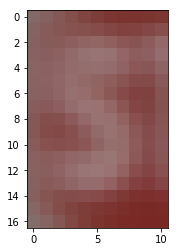

Sample closest to the mean


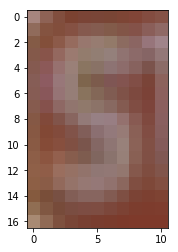

L2 dist from mean: 1.0824


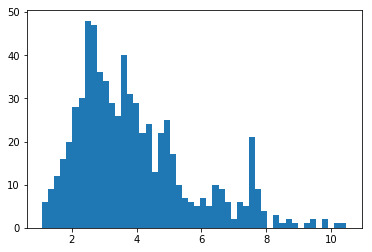

In [10]:
# Try transformaing 'S'
print("Mean of RGB image")
mean = np.mean(S, axis=0)
plt.imshow(mean)
plt.show()
    
# Sample that's closest to the mean
dist = np.sqrt(np.sum(np.square(S - mean).reshape(S.shape[0], -1), axis=1))
ind_center = np.argmin(dist)
print("Sample closest to the mean")
x_mean = S[ind_center]
plt.imshow(x_mean)
plt.show()
print("L2 dist from mean: {:.4f}".format(dist[ind_center]))
plt.hist(dist, bins=50)
plt.show()

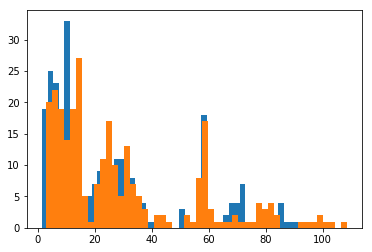

In [13]:
dist_S = np.sum((S_test - mean)**2, (1, 2, 3))
dist_O = np.sum((O_test - mean)**2, (1, 2, 3))
plt.hist(dist_S, bins=50)
plt.hist(dist_O, bins=50)
plt.show()

## 2. Distance to mean in HSV

https://en.wikipedia.org/wiki/Mean_of_circular_quantities

In [12]:
def hsv_dist(image_a, image_b):
    
    out = np.zeros_like(image_a)
    dist1 = np.square(image_a - image_b)
    out[:, :, 1:] = dist1[:, :, 1:]
    
    # Hue distance
    dist2 = np.square(image_a + 1 - image_b)
    dist3 = np.square(image_a - image_b - 1)
    dist = np.minimum(dist1, dist2)
    out[:, :, 0] = np.minimum(dist, dist3)[:, :, 0]
    return out

def hsv_mean(images):
    
    from scipy.stats import circmean
    out = np.zeros_like(images[0])
    out[:, :, 1:] = np.mean(images[:, :, :, 1:], axis=0)
    out[:, :, 0] = circmean(images[:, :, :, 0], high=1, low=0, axis=0)
    return out

def hsv_std(images):
    
    from scipy.stats import circstd
    out = np.zeros_like(images[0])
    out[:, :, 1:] = np.std(images[:, :, :, 1:], axis=0)
    out[:, :, 0] = circstd(images[:, :, :, 0], high=1, low=0, axis=0)
    return out

Mean of HSV image


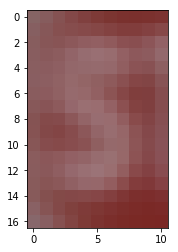

In [56]:
print("Mean of HSV image")
S_hsv = matplotlib.colors.rgb_to_hsv(S)
mean = hsv_mean(S_hsv)
plt.imshow(matplotlib.colors.hsv_to_rgb(mean))
plt.show()

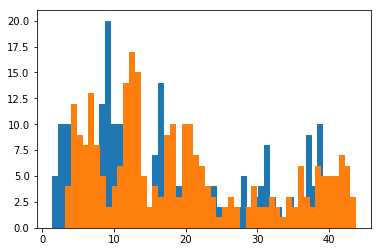

In [57]:
dist = np.array([hsv_dist(x, mean) for x in matplotlib.colors.rgb_to_hsv(S_test)])
dist_S = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean) for x in matplotlib.colors.rgb_to_hsv(O_test)])
dist_O = np.sum(dist, (1, 2, 3))
plt.hist(dist_S, bins=50)
plt.hist(dist_O, bins=50)
plt.show()

## 3. Distance to mean in Hue

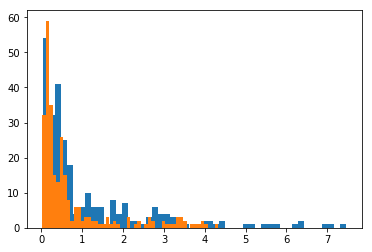

In [58]:
dist = np.array([hsv_dist(x, mean) for x in matplotlib.colors.rgb_to_hsv(S_test)])
dist_S = np.sum(dist[:, :, :, 0], (1, 2))
dist = np.array([hsv_dist(x, mean) for x in matplotlib.colors.rgb_to_hsv(O_test)])
dist_O = np.sum(dist[:, :, :, 0], (1, 2))
plt.hist(dist_S, bins=50)
plt.hist(dist_O, bins=50)
plt.show()

## 4. NN to mean

Mean of HSV image


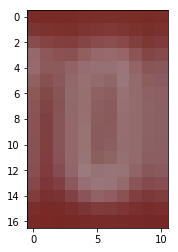

In [34]:
print("Mean of HSV image")
O_hsv = matplotlib.colors.rgb_to_hsv(O)
mean = hsv_mean(O_hsv)
plt.imshow(matplotlib.colors.hsv_to_rgb(mean))
plt.show()

In [59]:
S_hsv = matplotlib.colors.rgb_to_hsv(S)
mean_S = hsv_mean(S_hsv)
O_hsv = matplotlib.colors.rgb_to_hsv(O)
mean_O = hsv_mean(O_hsv)

dist = np.array([hsv_dist(x, mean_S) for x in matplotlib.colors.rgb_to_hsv(S_test)])
dist_SS = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_O) for x in matplotlib.colors.rgb_to_hsv(S_test)])
dist_SO = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_O) for x in matplotlib.colors.rgb_to_hsv(O_test)])
dist_OO = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_S) for x in matplotlib.colors.rgb_to_hsv(O_test)])
dist_OS = np.sum(dist, (1, 2, 3))

print(np.sum(dist_SS < dist_SO))
print(np.sum(dist_OO < dist_OS))

269
264


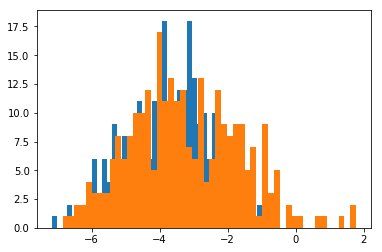

In [63]:
diff = dist_SS - dist_SO
plt.hist(diff, bins=50)
diff = dist_OO - dist_OS
plt.hist(diff, bins=50)
plt.show()

## 5. NN to mean with HSV and binarization

8-bit info

269
264


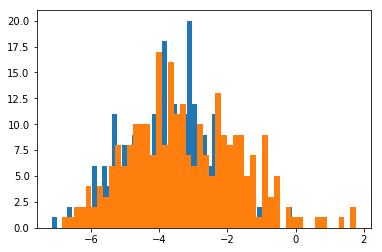

In [65]:
S_bin = (matplotlib.colors.rgb_to_hsv(S_test) * 255).astype(np.int32) / 255.
O_bin = (matplotlib.colors.rgb_to_hsv(O_test) * 255).astype(np.int32) / 255.
mean_S_bin = (mean_S * 255).astype(np.int32) / 255.
mean_O_bin = (mean_O * 255).astype(np.int32) / 255.

dist = np.array([hsv_dist(x, mean_S_bin) for x in S_bin])
dist_SS = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_O_bin) for x in S_bin])
dist_SO = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_O_bin) for x in O_bin])
dist_OO = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_S_bin) for x in O_bin])
dist_OS = np.sum(dist, (1, 2, 3))

print(np.sum(dist_SS < dist_SO))
print(np.sum(dist_OO < dist_OS))

diff = dist_SS - dist_SO
plt.hist(diff, bins=50)
diff = dist_OO - dist_OS
plt.hist(diff, bins=50)
plt.show()

Binary

129
228


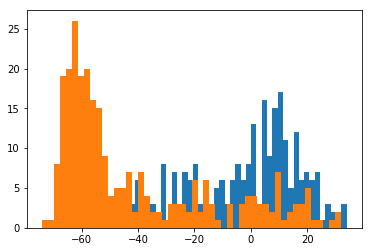

In [66]:
S_bin = (matplotlib.colors.rgb_to_hsv(S_test) > 0.5).astype(np.float32)
O_bin = (matplotlib.colors.rgb_to_hsv(O_test) > 0.5).astype(np.float32)
mean_S_bin = (mean_S > 0.5).astype(np.float32)
mean_O_bin = (mean_O > 0.5).astype(np.float32)

dist = np.array([hsv_dist(x, mean_S_bin) for x in S_bin])
dist_SS = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_O_bin) for x in S_bin])
dist_SO = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_O_bin) for x in O_bin])
dist_OO = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_S_bin) for x in O_bin])
dist_OS = np.sum(dist, (1, 2, 3))

print(np.sum(dist_SS < dist_SO))
print(np.sum(dist_OO < dist_OS))

diff = dist_SS - dist_SO
plt.hist(diff, bins=50)
diff = dist_OO - dist_OS
plt.hist(diff, bins=50)
plt.show()

## Experiment with more features

In [10]:
from skimage.transform import resize

size = (16, 16)
pos = [pos_S, pos_T, pos_O, pos_P]

X_stop = X_train[np.where(y_train == 14)]
X_stn = get_stn_output([X_stop, 0])[0]*0.5 + 0.5
feat_train = [np.array([resize(x, size, order=1) for x in get_patch(X_stn, p)]) for p in pos]
X_stop = X_test[np.where(y_test == 14)]
X_stn = get_stn_output([X_stop, 0])[0]*0.5 + 0.5
feat_test = [np.array([resize(x, size, order=1) for x in get_patch(X_stn, p)]) for p in pos]

feat_train = [matplotlib.colors.rgb_to_hsv(f) for f in feat_train]
feat_test = [matplotlib.colors.rgb_to_hsv(f) for f in feat_test]

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


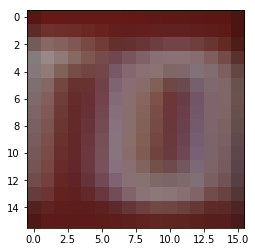

In [115]:
plt.imshow(matplotlib.colors.hsv_to_rgb(feat_train[2][80]))

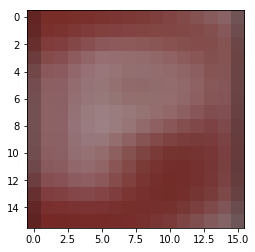

In [116]:
mean_hsv = [hsv_mean(f) for f in feat_train]

plt.imshow(matplotlib.colors.hsv_to_rgb(mean_hsv[3]))

In [110]:
mean_hsv = [(mean * 255).astype(np.int32) / 255. for mean in mean_hsv]
feat_train = [(f * 255).astype(np.int32) / 255. for f in feat_train]
feat_test = [(f * 255).astype(np.int32) / 255. for f in feat_test]

In [117]:
dist_all = []
for feat in feat_train:
    dist_feat = []
    for x in feat:
        dist = np.array([np.sum(hsv_dist(x, mean)) for mean in mean_hsv])
        dist_feat.append(dist)
    dist_all.append(np.array(dist_feat))
    
for feat in range(4):
    f_close = np.argmin(dist_all[feat], axis=1)
#     print(np.sum(f_close == feat))
    print(np.sum(f_close == 0), np.sum(f_close == 1), np.sum(f_close == 2), np.sum(f_close == 3))

580 110 0 0
36 572 80 2
6 59 624 1
1 19 13 657


In [118]:
dist_all = []
for feat in feat_test:
    dist_feat = []
    for x in feat:
        dist = np.array([np.sum(hsv_dist(x, mean)) for mean in mean_hsv])
        dist_feat.append(dist)
    dist_all.append(np.array(dist_feat))

for feat in range(4):
    f_close = np.argmin(dist_all[feat], axis=1)
#     print(np.sum(f_close == feat))
    print(np.sum(f_close == 0), np.sum(f_close == 1), np.sum(f_close == 2), np.sum(f_close == 3))

235 35 0 0
31 207 26 6
6 41 219 4
12 5 2 251


## 6. Hue Threshold

Manually set

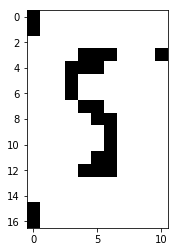

In [32]:
thres = [0, 0.65, 0.5]
width = [0.1, 1 - thres[1], 1 - thres[2]]

S_hsv = matplotlib.colors.rgb_to_hsv(S)
mean_S = hsv_mean(S_hsv)
thres_hsv = np.zeros_like(mean_S) + thres
dist = hsv_dist(mean_S, thres_hsv)
diff = (np.zeros_like(mean_S) + width)**2
out = np.sum(dist < diff, axis=2) // 3

plt.imshow(out, cmap='gray')
plt.show()

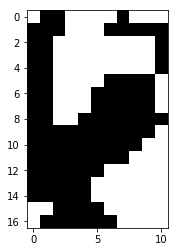

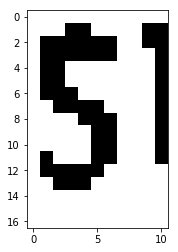

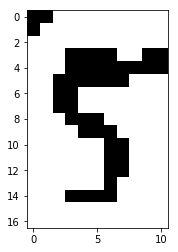

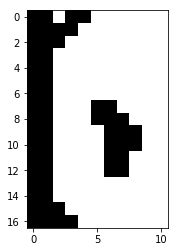

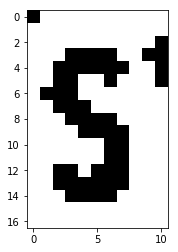

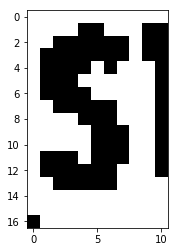

In [33]:
for i in [0, 50, 100, 150, 200, 250]:
    dist = np.sqrt(hsv_dist(S_hsv[i], thres_hsv))
    diff = np.zeros_like(S_hsv[i]) + width
    out = np.sum(dist < diff, axis=2) // 3
    plt.imshow(out, cmap='gray')
    plt.show()

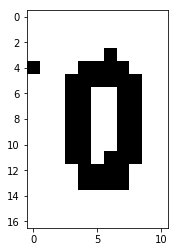

In [34]:
O_hsv = matplotlib.colors.rgb_to_hsv(O)
mean_O = hsv_mean(O_hsv)
thres_hsv = np.zeros_like(mean_O) + thres
dist = hsv_dist(mean_O, thres_hsv)
diff = (np.zeros_like(mean_O) + width)**2
out = np.sum(dist < diff, axis=2) // 3

plt.imshow(out, cmap='gray')
plt.show()

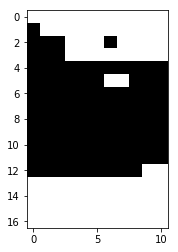

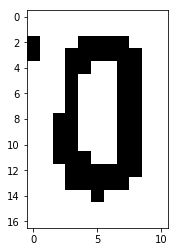

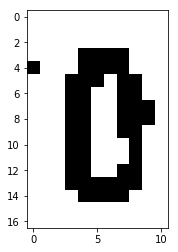

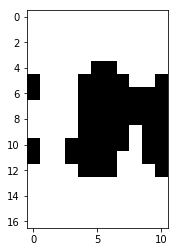

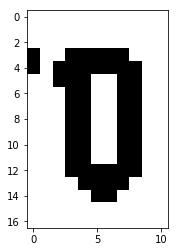

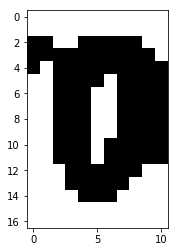

In [35]:
for i in [0, 50, 100, 150, 200, 250]:
    dist = np.sqrt(hsv_dist(O_hsv[i], thres_hsv))
    diff = np.zeros_like(O_hsv[i]) + width
    out = np.sum(dist < diff, axis=2) // 3
    plt.imshow(out, cmap='gray')
    plt.show()

Try to adjust mean first in RGB

In [15]:
mean = np.mean(S)
S_center = np.array([x - np.mean(x) + mean for x in S])

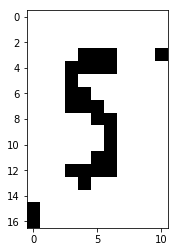

In [27]:
thres = [0, 0.65, 0.5]
width = [0.1, 1 - thres[1], 1 - thres[2]]

S_hsv = matplotlib.colors.rgb_to_hsv(S_center)
mean_S = hsv_mean(S_hsv)
thres_hsv = np.zeros_like(mean_S) + thres
dist = hsv_dist(mean_S, thres_hsv)
diff = (np.zeros_like(mean_S) + width)**2
out = np.sum(dist < diff, axis=2) // 3

plt.imshow(out, cmap='gray')
plt.show()

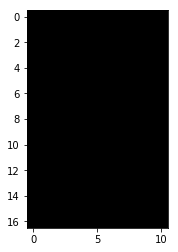

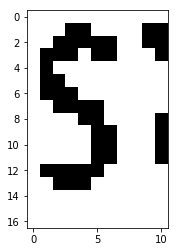

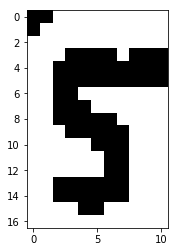

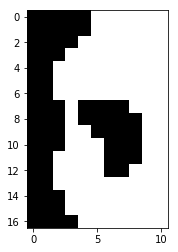

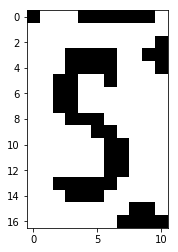

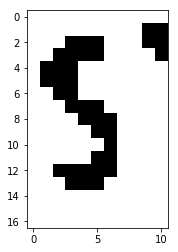

In [28]:
for i in [0, 50, 100, 150, 200, 250]:
    dist = np.sqrt(hsv_dist(S_hsv[i], thres_hsv))
    diff = np.zeros_like(S_hsv[i]) + width
    out = np.sum(dist < diff, axis=2) // 3
    plt.imshow(out, cmap='gray')
    plt.show()

## Neural Network Approach  

Use neural network confidence score as output to another classifier which takes N real numbers (N is number of features per class) and outputs a final confidence for how likely the proposed label is correct. Probably need some confidence score calibration.

Problem:  
- how do we label "bad samples" e.g. not really visible S on a stop sign?

## Nearest Neighbor

We evaluate nearest neighbors of S by measuring distance from S to S and from non-S to S. For non-S, we pick O as a representative as it should be very close to S (use O as a bound).  

Problem: how do we justify if it's robust?  
In other words, just because it works for distinguishing some features like S from O, it doesn't prvide any guarantee of its robustness or how "good" it is to other digits.

In [9]:
dist_SS = np.zeros([len(S_test), len(S)])
dist_OS = np.zeros([len(O_test), len(S)])

for i, s in enumerate(S_test):
    dist_SS[i] = np.sum((S - s)**2, axis=(1, 2, 3))
for i, o in enumerate(O_test):
    dist_OS[i] = np.sum((S - o)**2, axis=(1, 2, 3))

Average


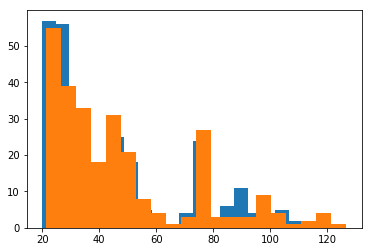

Minimum


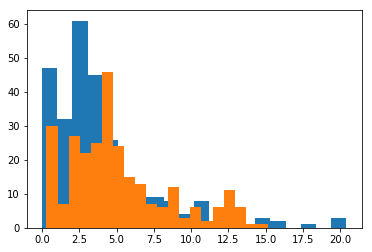

Median


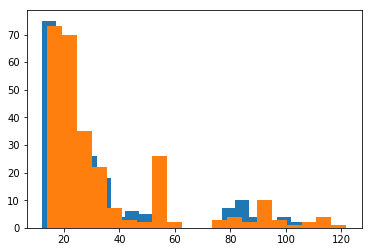

In [29]:
print("Average")
plt.hist(np.mean(dist_SS, axis=1), bins=20)
plt.hist(np.mean(dist_OS, axis=1), bins=20)
plt.show()

print("Minimum")
plt.hist(np.min(dist_SS, axis=1), bins=20)
plt.hist(np.min(dist_OS, axis=1), bins=20)
plt.show()

print("Median")
plt.hist(np.median(dist_SS, axis=1), bins=20)
plt.hist(np.median(dist_OS, axis=1), bins=20)
plt.show()

Average of smallest k


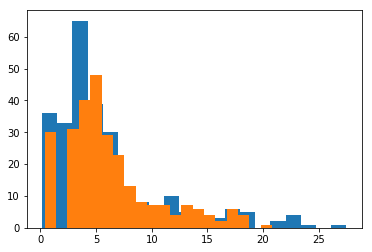

In [46]:
print("Average of smallest k")
plt.hist(np.mean(np.sort(dist_SS)[:, :20], axis=1), bins=20)
plt.hist(np.mean(np.sort(dist_OS)[:, :20], axis=1), bins=20)
plt.show()

Looking at distance distribution simply does not work. This is different from normal kNN.  
kNN, in a way, considers "relative distance."  

We cannot implement kNN naively because we want to determine not only which feature an input is closest to but also how close. But unfortunately, distance (l2) is a meaningless metric. Eg. X is closer to S than to O, but that does not mean X is S.

Arguably, we can still implement something more like kNN, but now we need to combine all possible features so we can say with more confident. BUT then again l2 is not a good metric so it's pointless.